# 1. Setup

## 1.1 Install Dependencies

In [5]:
!pip install tensorflow opencv-python matplotlib


Defaulting to user installation because normal site-packages is not writeable


## 1.2 Import Dependencies

In [6]:
# Import standard dependencies
import cv2
import os
import random
import numpy as np
from matplotlib import pyplot as plt

In [7]:
# Import tensorflow dependencies - Functional API
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer, Conv2D, Dense, MaxPooling2D, Input, Flatten
import tensorflow as tf

## 1.3 Set GPU Growth

In [8]:
# Avoid OOM errors by setting GPU Memory Consumption Growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus: 
    tf.config.experimental.set_memory_growth(gpu, True)

## 1.4 Create Folder Structures

In [9]:
# Setup paths
POS_PATH = os.path.join('data', 'positive')
NEG_PATH = os.path.join('data', 'negative')
ANC_PATH = os.path.join('data', 'anchor')

In [10]:
# Make the directories
os.makedirs(POS_PATH)
os.makedirs(NEG_PATH)
os.makedirs(ANC_PATH)

# 2. Collect Positives and Anchors

## 2.1 Untar Labelled Faces in the Wild Dataset

In [1]:
# http://vis-www.cs.umass.edu/lfw/

In [21]:
# Move  Images to the following repository data/negative
for directory in os.listdir('lfw111'):
    for file in os.listdir(os.path.join('lfw111', directory)):
        EX_PATH = os.path.join('lfw111', directory, file)
        NEW_PATH = os.path.join(NEG_PATH, file)
        os.replace(EX_PATH, NEW_PATH)

## 2.2 Collect Positive and Anchor Classes

In [22]:
# Import uuid library to generate unique image names
import uuid

In [23]:
os.path.join(ANC_PATH, '{}.jpg'.format(uuid.uuid1()))

'data\\anchor\\6f2c7a92-5791-11ef-92e4-c5d79fa9301a.jpg'

In [24]:
# Establish a connection to the webcam
cap = cv2.VideoCapture(4)
while cap.isOpened(): 
    ret, frame = cap.read()
   
    # Cut down frame to 250x250px
    frame = frame[120:120+250,200:200+250, :]
    
    # Collect anchors 
    if cv2.waitKey(1) & 0XFF == ord('a'):
        # Create the unique file path 
        imgname = os.path.join(ANC_PATH, '{}.jpg'.format(uuid.uuid1()))
        # Write out anchor image
        cv2.imwrite(imgname, frame)
    
    # Collect positives
    if cv2.waitKey(1) & 0XFF == ord('p'):
        # Create the unique file path 
        imgname = os.path.join(POS_PATH, '{}.jpg'.format(uuid.uuid1()))
        # Write out positive image
        cv2.imwrite(imgname, frame)
    
    # Show image back to screen
    cv2.imshow('Image Collection', frame)
    
    # Breaking gracefully
    if cv2.waitKey(1) & 0XFF == ord('q'):
        break
        
# Release the webcam
cap.release()
# Close the image show frame
cv2.destroyAllWindows()

# 3. Load and Preprocess Images

## 3.1 Get Image Directories

In [105]:
anchor = tf.data.Dataset.list_files(rf"{ANC_PATH}/*.jpg").take(300)
positive = tf.data.Dataset.list_files(rf"{POS_PATH}/*.jpg").take(300)
negative = tf.data.Dataset.list_files(rf"{NEG_PATH}/*.jpg").take(300)


In [106]:
dir_test = anchor.as_numpy_iterator()

In [107]:
print(dir_test.next())

b'data\\anchor\\47ba939e-561f-11ef-9208-c5d79fa9301a.jpg'


## 3.2 Preprocessing - Scale and Resize

In [108]:
def preprocess(file_path):
    
    # Read in image from file path
    byte_img = tf.io.read_file(file_path)
    # Load in the image 
    img = tf.io.decode_jpeg(byte_img)
    
    # Preprocessing steps - resizing the image to be 100x100x3
    img = tf.image.resize(img, (100,100))
    # Scale image to be between 0 and 1 
    img = img / 255.0
    
    # Return image
    return img

## 3.3 Create Labelled Dataset

In [8]:
# (anchor, positive) => 1,1,1,1,1
# (anchor, negative) => 0,0,0,0,0

In [109]:
positives = tf.data.Dataset.zip((anchor, positive, tf.data.Dataset.from_tensor_slices(tf.ones(len(anchor)))))
negatives = tf.data.Dataset.zip((anchor, negative, tf.data.Dataset.from_tensor_slices(tf.zeros(len(anchor)))))
data = positives.concatenate(negatives)

In [110]:
samples = data.as_numpy_iterator()

In [111]:
exampple = samples.next()

In [112]:
exampple

(b'data\\anchor\\5ca08342-561f-11ef-aa5d-c5d79fa9301a.jpg',
 b'data\\positive\\250aa167-5221-11ef-9f2b-b48c9d8bbb0e.jpg',
 1.0)

## 3.4 Build Train and Test Partition

In [113]:
def preprocess_twin(input_img, validation_img, label):
    return(preprocess(input_img), preprocess(validation_img), label)

In [114]:
res = preprocess_twin(*exampple)

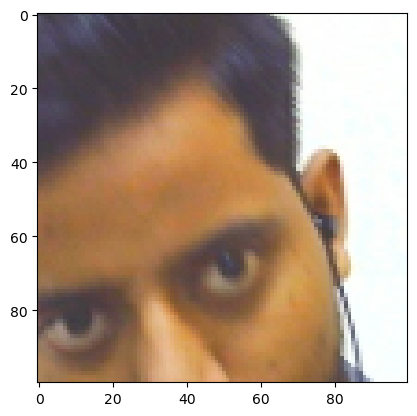

In [115]:
plt.imshow(res[1])

In [116]:
res[2]

1.0

In [117]:
# Build dataloader pipeline
data = data.map(preprocess_twin)
data = data.cache()
data = data.shuffle(buffer_size=1024)

In [118]:
# Training partition
train_data = data.take(round(len(data)*.7))
train_data = train_data.batch(16)
train_data = train_data.prefetch(8)

In [119]:
# Testing partition
test_data = data.skip(round(len(data)*.7))
test_data = test_data.take(round(len(data)*.3))
test_data = test_data.batch(16)
test_data = test_data.prefetch(8)

# 4. Model Engineering

## 4.1 Build Embedding Layer

In [120]:
inp = Input(shape=(100,100,3), name='input_image')

In [121]:
c1 = Conv2D(64, (10,10), activation='relu')(inp)

In [122]:
m1 = MaxPooling2D(64, (2,2), padding='same')(c1)

In [123]:
c2 = Conv2D(128, (7,7), activation='relu')(m1)
m2 = MaxPooling2D(64, (2,2), padding='same')(c2)

In [124]:
c3 = Conv2D(128, (4,4), activation='relu')(m2)
m3 = MaxPooling2D(64, (2,2), padding='same')(c3)

In [125]:
c4 = Conv2D(256, (4,4), activation='relu')(m3)
f1 = Flatten()(c4)
d1 = Dense(4096, activation='sigmoid')(f1)

In [126]:
mod = Model(inputs=[inp], outputs=[d1], name='embedding')

In [127]:
mod.summary()

Model: "embedding"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_image (InputLayer)             │ (None, 100, 100, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_9 (Conv2D)                    │ (None, 91, 91, 64)          │          19,264 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_7 (MaxPooling2D)       │ (None, 46, 46, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_10 (Conv2D)                   │ (None, 40, 40, 128)         │         401,536 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_8 (MaxPooling2D)       │ (None, 20, 20, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_11 (Conv2D)                   │ (None, 17, 17, 128)         │         262,272 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_9 (MaxPooling2D)       │ (None, 9, 9, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_12 (Conv2D)                   │ (None, 6, 6, 256)           │         524,544 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_3 (Flatten)                  │ (None, 9216)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 4096)                │      37,752,832 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 38,960,448 (148.62 MB)

 Trainable params: 38,960,448 (148.62 MB)

 Non-trainable params: 0 (0.00 B)

In [128]:
def make_embedding(): 
    inp = Input(shape=(100,100,3), name='input_image')
    
    # First block
    c1 = Conv2D(64, (10,10), activation='relu')(inp)
    m1 = MaxPooling2D(64, (2,2), padding='same')(c1)
    
    # Second block
    c2 = Conv2D(128, (7,7), activation='relu')(m1)
    m2 = MaxPooling2D(64, (2,2), padding='same')(c2)
    
    # Third block 
    c3 = Conv2D(128, (4,4), activation='relu')(m2)
    m3 = MaxPooling2D(64, (2,2), padding='same')(c3)
    
    # Final embedding block
    c4 = Conv2D(256, (4,4), activation='relu')(m3)
    f1 = Flatten()(c4)
    d1 = Dense(4096, activation='sigmoid')(f1)
    
    
    return Model(inputs=[inp], outputs=[d1], name='embedding')

In [129]:
embedding = make_embedding()

In [130]:
embedding.summary()

Model: "embedding"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_image (InputLayer)             │ (None, 100, 100, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_13 (Conv2D)                   │ (None, 91, 91, 64)          │          19,264 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_10 (MaxPooling2D)      │ (None, 46, 46, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_14 (Conv2D)                   │ (None, 40, 40, 128)         │         401,536 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_11 (MaxPooling2D)      │ (None, 20, 20, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_15 (Conv2D)                   │ (None, 17, 17, 128)         │         262,272 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_12 (MaxPooling2D)      │ (None, 9, 9, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_16 (Conv2D)                   │ (None, 6, 6, 256)           │         524,544 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_4 (Flatten)                  │ (None, 9216)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 4096)                │      37,752,832 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 38,960,448 (148.62 MB)

 Trainable params: 38,960,448 (148.62 MB)

 Non-trainable params: 0 (0.00 B)

## 4.2 Build Distance Layer

In [131]:
import tensorflow as tf
from tensorflow.keras.layers import Layer

class L1Dist(Layer):
    def __init__(self, **kwargs):
        super(L1Dist, self).__init__(**kwargs)

    def call(self, input_embedding, validation_embedding):
        return tf.math.abs(input_embedding - validation_embedding)


In [132]:
l1 = L1Dist()

## 4.3 Make Siamese Model

In [134]:
input_image = Input(name='input_img', shape=(100,100,3))
validation_image = Input(name='validation_img', shape=(100,100,3))

In [135]:
inp_embedding = embedding(input_image)
val_embedding = embedding(validation_image)

In [136]:
siamese_layer = L1Dist()

In [138]:
# Assuming inp_embedding and val_embedding are lists of tensors, extract the tensors
inp_embedding = inp_embedding[0] if isinstance(inp_embedding, list) else inp_embedding
val_embedding = val_embedding[0] if isinstance(val_embedding, list) else val_embedding

# Now pass the tensors to your custom layer
distances = siamese_layer(inp_embedding, val_embedding)


In [139]:
distances = siamese_layer(inp_embedding, val_embedding)

In [140]:
classifier = Dense(1, activation='sigmoid')(distances)

In [141]:
classifier

<KerasTensor shape=(None, 1), dtype=float32, sparse=False, name=keras_tensor_71>

In [142]:
siamese_network = Model(inputs=[input_image, validation_image], outputs=classifier, name='SiameseNetwork')

In [143]:
siamese_network.summary()

Model: "SiameseNetwork"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_img (InputLayer)        │ (None, 100, 100, 3)       │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ validation_img (InputLayer)   │ (None, 100, 100, 3)       │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ embedding (Functional)        │ (None, 4096)              │      38,960,448 │ input_img[0][0],           │
│                               │                           │                 │ validation_img[0][0]       │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ l1_dist_12 (L1Dist)           │ (None, 4096)              │               0 │ embedding[0][0],           │
│                               │                           │                 │ embedding[1][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_9 (Dense)               │ (None, 1)                 │           4,097 │ l1_dist_12[1][0]           │
└───────────────────────────────┴───────────────────────────┴─────────────────┴────────────────────────────┘

 Total params: 38,964,545 (148.64 MB)

 Trainable params: 38,964,545 (148.64 MB)

 Non-trainable params: 0 (0.00 B)

In [146]:
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model

def make_siamese_model(): 
    

    # Anchor image input in the network
    input_image = Input(name='input_img', shape=(100, 100, 3))
    
    # Validation image in the network 
    validation_image = Input(name='validation_img', shape=(100, 100, 3))
    
    
    # Pass inputs through the embedding model
    input_embedding = embedding(input_image)
    validation_embedding = embedding(validation_image)
    
    # Combine siamese distance components
    siamese_layer = L1Dist()
    siamese_layer._name = 'distance'
    # Assuming inp_embedding and val_embedding are lists of tensors, extract the tensors
    input_embedding = input_embedding[0] if isinstance(input_embedding, list) else input_embedding
    validation_embedding = validation_embedding[0] if isinstance(validation_embedding, list) else validation_embedding
    distances = siamese_layer(input_embedding, validation_embedding)
    
    # Classification layer 
    classifier = Dense(1, activation='sigmoid')(distances)
    
    return Model(inputs=[input_image, validation_image], outputs=classifier, name='SiameseNetwork')


In [147]:
siamese_model = make_siamese_model()

In [104]:
siamese_model.summary()

Model: "SiameseNetwork"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_img (InputLayer)        │ (None, 100, 100, 3)       │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ validation_img (InputLayer)   │ (None, 100, 100, 3)       │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ sequential (Sequential)       │ (None, 4096)              │     530,864,960 │ input_img[0][0],           │
│                               │                           │                 │ validation_img[0][0]       │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ l1_dist_10 (L1Dist)           │ (None, 4096)              │               0 │ sequential[0][0],          │
│                               │                           │                 │ sequential[1][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_6 (Dense)               │ (None, 1)                 │           4,097 │ l1_dist_10[0][0]           │
└───────────────────────────────┴───────────────────────────┴─────────────────┴────────────────────────────┘

 Total params: 530,869,057 (1.98 GB)

 Trainable params: 530,869,057 (1.98 GB)

 Non-trainable params: 0 (0.00 B)

# 5. Training

## 5.1 Setup Loss and Optimizer

In [148]:
binary_cross_loss = tf.losses.BinaryCrossentropy()

In [149]:
opt = tf.keras.optimizers.Adam(1e-4) # 0.0001

## 5.2 Establish Checkpoints

In [150]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, 'ckpt')
checkpoint = tf.train.Checkpoint(opt=opt, siamese_model=siamese_model)

## 5.3 Build Train Step Function

In [151]:
test_batch = train_data.as_numpy_iterator()

In [152]:
batch_1 = test_batch.next()

In [153]:
X = batch_1[:2]

In [154]:
y = batch_1[2]

In [155]:
y

array([0., 1., 0., 0., 0., 1., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0.],
      dtype=float32)

In [157]:
tf.losses.BinaryCrossentropy??

Init signature:
tf.losses.BinaryCrossentropy(
    from_logits=False,
    label_smoothing=0.0,
    axis=-1,
    reduction='sum_over_batch_size',
    name='binary_crossentropy',
    dtype=None,
)
Source:        
@keras_export("keras.losses.BinaryCrossentropy")
class BinaryCrossentropy(LossFunctionWrapper):
    """Computes the cross-entropy loss between true labels and predicted labels.

    Use this cross-entropy loss for binary (0 or 1) classification applications.
    The loss function requires the following inputs:

    - `y_true` (true label): This is either 0 or 1.
    - `y_pred` (predicted value): This is the model's prediction, i.e, a single
        floating-point value which either represents a
        [logit](https://en.wikipedia.org/wiki/Logit), (i.e, value in [-inf, inf]
        when `from_logits=True`) or a probability (i.e, value in [0., 1.] when
        `from_logits=False`).

    Args:
        from_logits: Whether to interpret `y_pred` as a tensor of
            [logit](htt

In [158]:
@tf.function
def train_step(batch):
    
    # Record all of our operations 
    with tf.GradientTape() as tape:     
        # Get anchor and positive/negative image
        X = batch[:2]
        # Get label
        y = batch[2]
        
        # Forward pass
        yhat = siamese_model(X, training=True)
        # Calculate loss
        loss = binary_cross_loss(y, yhat)
    print(loss)
        
    # Calculate gradients
    grad = tape.gradient(loss, siamese_model.trainable_variables)
    
    # Calculate updated weights and apply to siamese model
    opt.apply_gradients(zip(grad, siamese_model.trainable_variables))
    
    # Return loss
    return loss

## 5.4 Build Training Loop

In [159]:
def train(data, EPOCHS):
    # Loop through epochs
    for epoch in range(1, EPOCHS+1):
        print('\n Epoch {}/{}'.format(epoch, EPOCHS))
        progbar = tf.keras.utils.Progbar(len(data))
        
        # Loop through each batch
        for idx, batch in enumerate(data):
            # Run train step here
            train_step(batch)
            progbar.update(idx+1)
        
        # Save checkpoints
        if epoch % 10 == 0: 
            checkpoint.save(file_prefix=checkpoint_prefix)

## 5.5 Train the model

In [160]:
EPOCHS = 50

In [161]:
train(train_data, EPOCHS)


 Epoch 1/50
Tensor("binary_crossentropy/truediv:0", shape=(), dtype=float32)
Tensor("binary_crossentropy/truediv:0", shape=(), dtype=float32)
26/27 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/stepTensor("binary_crossentropy/truediv:0", shape=(), dtype=float32)
27/27 ━━━━━━━━━━━━━━━━━━━━ 56s 2s/step

 Epoch 2/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 57s 2s/step

 Epoch 3/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 55s 2s/step

 Epoch 4/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 55s 2s/step

 Epoch 5/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 54s 2s/step

 Epoch 6/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 55s 2s/step

 Epoch 7/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 55s 2s/step

 Epoch 8/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 56s 2s/step

 Epoch 9/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 55s 2s/step

 Epoch 10/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 59s 2s/step

 Epoch 11/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 58s 2s/step

 Epoch 12/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 54s 2s/step

 Epoch 13/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 56s 2s/step

 Epoch 14/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 59s 2s/step

 Epoch 15/50
27/27 ━━━━━━━━━━━━━━━

# 6. Evaluate Model

## 6.1 Import Metrics

In [164]:
# Import metric calculations
from tensorflow.keras.metrics import Precision, Recall

## 6.2 Make Predictions

In [165]:
# Get a batch of test data
test_input, test_val, y_true = test_data.as_numpy_iterator().next()

In [166]:
# Make predictions
y_hat = siamese_model.predict([test_input, test_val])
y_hat

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 662ms/step


array([[1.11989792e-07],
       [9.99932587e-01],
       [1.13136586e-07],
       [1.18830108e-07],
       [8.36603036e-08],
       [9.56377153e-06],
       [1.00000000e+00],
       [1.00000000e+00],
       [1.00000000e+00],
       [1.00000000e+00],
       [1.00000000e+00],
       [1.00000000e+00],
       [1.00000000e+00],
       [4.44016424e-09],
       [1.00000000e+00],
       [1.00000000e+00]], dtype=float32)

In [167]:
# Post processing the results 
[1 if prediction > 0.5 else 0 for prediction in y_hat ]

[0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1]

In [168]:
y_true

array([0., 1., 0., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1.],
      dtype=float32)

## 6.3 Calculate Metrics

In [169]:
# Creating a metric object 
m = Recall()

# Calculating the recall value 
m.update_state(y_true, y_hat)

# Return Recall Result
m.result().numpy()

1.0

In [170]:
# Creating a metric object 
m = Precision()

# Calculating the recall value 
m.update_state(y_true, y_hat)

# Return Recall Result
m.result().numpy()

1.0

## 6.4 Viz Results

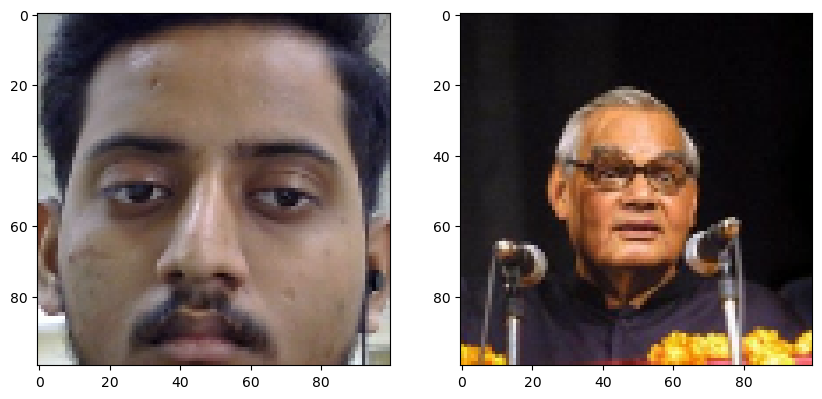

In [171]:
# Set plot size 
plt.figure(figsize=(10,8))

# Set first subplot
plt.subplot(1,2,1)
plt.imshow(test_input[0])

# Set second subplot
plt.subplot(1,2,2)
plt.imshow(test_val[0])

# Renders cleanly
plt.show()

# 7. Save Model

In [172]:
# Save weights
siamese_model.save('siamesemodel.h5')

In [173]:
L1Dist

__main__.L1Dist

In [174]:
# Reload model 
model = tf.keras.models.load_model('siamesemodel.h5', 
                                   custom_objects={'L1Dist':L1Dist, 'BinaryCrossentropy':tf.losses.BinaryCrossentropy})

In [175]:
# Make predictions with reloaded model
model.predict([test_input, test_val])

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 502ms/step


array([[1.11989792e-07],
       [9.99932587e-01],
       [1.13136586e-07],
       [1.18830108e-07],
       [8.36603036e-08],
       [9.56377153e-06],
       [1.00000000e+00],
       [1.00000000e+00],
       [1.00000000e+00],
       [1.00000000e+00],
       [1.00000000e+00],
       [1.00000000e+00],
       [1.00000000e+00],
       [4.44016424e-09],
       [1.00000000e+00],
       [1.00000000e+00]], dtype=float32)

In [176]:
# View model summary
model.summary()

Model: "SiameseNetwork"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_img (InputLayer)        │ (None, 100, 100, 3)       │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ validation_img (InputLayer)   │ (None, 100, 100, 3)       │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ embedding (Functional)        │ (None, 4096)              │      38,960,448 │ input_img[0][0],           │
│                               │                           │                 │ validation_img[0][0]       │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ l1_dist_14 (L1Dist)           │ (None, 4096)              │               0 │ embedding[0][0],           │
│                               │                           │                 │ embedding[1][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_10 (Dense)              │ (None, 1)                 │           4,097 │ l1_dist_14[0][0]           │
└───────────────────────────────┴───────────────────────────┴─────────────────┴────────────────────────────┘

 Total params: 38,964,545 (148.64 MB)

 Trainable params: 38,964,545 (148.64 MB)

 Non-trainable params: 0 (0.00 B)

# 8. Real Time Test

## 8.1 Verification Function

In [184]:
os.listdir(os.path.join('application_data', 'verification_images'))

['234a1ed9-5221-11ef-819e-b48c9d8bbb0e.jpg',
 '23dc0c16-5221-11ef-9ebd-b48c9d8bbb0e.jpg',
 '23ff6a50-5221-11ef-b907-b48c9d8bbb0e.jpg',
 '2427d104-5221-11ef-8d00-b48c9d8bbb0e.jpg',
 '244b0182-5221-11ef-8d98-b48c9d8bbb0e.jpg',
 '247351e7-5221-11ef-8fd6-b48c9d8bbb0e.jpg',
 '2496b0e7-5221-11ef-8980-b48c9d8bbb0e.jpg',
 '24c3b640-5221-11ef-8f84-b48c9d8bbb0e.jpg',
 '24e226da-5221-11ef-b7b8-b48c9d8bbb0e.jpg',
 '250aa167-5221-11ef-9f2b-b48c9d8bbb0e.jpg',
 '2537be55-5221-11ef-841e-b48c9d8bbb0e.jpg',
 '2564cd6b-5221-11ef-8940-b48c9d8bbb0e.jpg',
 '2583681d-5221-11ef-9003-b48c9d8bbb0e.jpg',
 '25ab5601-5221-11ef-8f96-b48c9d8bbb0e.jpg',
 '25c9db35-5221-11ef-9d70-b48c9d8bbb0e.jpg',
 '25f22e46-5221-11ef-9086-b48c9d8bbb0e.jpg',
 '261a8596-5221-11ef-9fed-b48c9d8bbb0e.jpg',
 '2642ab01-5221-11ef-a74a-b48c9d8bbb0e.jpg',
 '266fd092-5221-11ef-97f6-b48c9d8bbb0e.jpg',
 '269314a8-5221-11ef-b3a7-b48c9d8bbb0e.jpg',
 '26d7abf7-5221-11ef-8b1c-b48c9d8bbb0e.jpg',
 '26decf46-5221-11ef-b535-b48c9d8bbb0e.jpg',
 '27073d6e

In [120]:
os.path.join('application_data', 'input_image', 'input_image.jpg')

'application_data\\input_image\\input_image.jpg'

In [122]:
for image in os.listdir(os.path.join('application_data', 'verification_images')):
    validation_img = os.path.join('application_data', 'verification_images', image)
    print(validation_img)

application_data\verification_images\c01703e8-135f-11ec-9c58-a0cec8d2d278.jpg
application_data\verification_images\c08e1f2e-135f-11ec-ab18-a0cec8d2d278.jpg
application_data\verification_images\c099e9f0-135f-11ec-86a7-a0cec8d2d278.jpg
application_data\verification_images\c0c715c0-135f-11ec-892f-a0cec8d2d278.jpg
application_data\verification_images\c0ef7814-135f-11ec-904e-a0cec8d2d278.jpg
application_data\verification_images\c202065a-135f-11ec-b0bc-a0cec8d2d278.jpg
application_data\verification_images\c22117d0-135f-11ec-926e-a0cec8d2d278.jpg
application_data\verification_images\c268919e-135f-11ec-bd66-a0cec8d2d278.jpg
application_data\verification_images\c2a3a158-135f-11ec-99bc-a0cec8d2d278.jpg
application_data\verification_images\c2afbad2-135f-11ec-b848-a0cec8d2d278.jpg
application_data\verification_images\c2e6ebc6-135f-11ec-911c-a0cec8d2d278.jpg
application_data\verification_images\c3aedf8a-135f-11ec-8753-a0cec8d2d278.jpg
application_data\verification_images\c3c988f4-135f-11ec-9c57-a0c

In [183]:
def verify(model, detection_threshold, verification_threshold):
    # Build results array
    results = []
    for image in os.listdir(os.path.join('application_data', 'verification_images')):
        input_img = preprocess(os.path.join('application_data', 'input_image', 'input_image.jpg'))
        validation_img = preprocess(os.path.join('application_data', 'verification_images', image))
        
        # Make Predictions 
        result = model.predict(list(np.expand_dims([input_img, validation_img], axis=1)))
        results.append(result)
    
    # Detection Threshold: Metric above which a prediciton is considered positive 
    detection = np.sum(np.array(results) > detection_threshold)
    
    # Verification Threshold: Proportion of positive predictions / total positive samples 
    verification = detection / len(os.listdir(os.path.join('application_data', 'verification_images'))) 
    verified = verification > verification_threshold
    
    return results, verified

## 8.2 OpenCV Real Time Verification

In [ ]:
cap = cv2.VideoCapture(0)
while cap.isOpened():
    ret, frame = cap.read()
    frame = frame[120:120+250,200:200+250, :]
    
    cv2.imshow('Verification', frame)
    
    # Verification trigger
    if cv2.waitKey(10) & 0xFF == ord('v'):
        # Save input image to application_data/input_image folder 
        cv2.imwrite(os.path.join('application_data', 'input_image', 'input_image.jpg'), frame)
        # Run verification
        results, verified = verify(model, 0.9, 0.7)
        print(verified)
    
    if cv2.waitKey(10) & 0xFF == ord('q'):
        break
cap.release()
cv2.destroyAllWindows()